# Text
#### Jan 3, 2021

## 1. Fetch data

In [1]:
import sqlalchemy
import configparser

# DB connection parameters
config = configparser.ConfigParser()
config.read('../db_config_final.ini')

host = config.get('database', 'host')
user = config.get('database', 'user')
passwd = config.get('database', 'passwd')


engine = sqlalchemy.create_engine('postgres://{0}:{1}@{2}:5432/{0}'.format(user, passwd, host, user))
meta = sqlalchemy.MetaData()
meta.reflect(bind=engine)

In [2]:
import pandas as pd

athletes_table = sqlalchemy.Table('athletes', meta, autoload=True)
q = athletes_table.select() # select query

dfa = pd.read_sql(q, engine)

In [3]:
posts_table = sqlalchemy.Table('posts', meta, autoload=True)
q = posts_table.select() # select query

dfp = pd.read_sql(q, engine)

### Merge and select relevant columns

In [4]:
df = dfa.merge(dfp, how='right', left_on='id', right_on='author')[['gender', 'performance_075xsigma', 'english_content']]

In [5]:
df.head()

gender performance_075xsigma  \
0      m                 under   
1      f                  over   
2      f                  over   
3      f                 under   
4      f                normal   

                                     english_content  
0  Special World Cup race yesterday in Unfortunat...  
1  Thank you for this experience and grateful mom...  
2  I DID IT!!!! One last medal in my final race.....  
3  When I said I wanted to make memories in my fi...  
4  You dream about it, you work for it, but when ...

## 2. Text clean-up

- Lemmatise verbs and nouns; (note I'm not de-lemmatising)
- Find collocations;
- Tokenize (collocations stay together);
- Remove stopwords.

In [6]:
import spacy

model = spacy.load('en_core_web_md')

def spacy_lemmatise(x):
    doc = model(x)
    # only lemmatise verbs and nouns
    doc_lemma = ' '.join([ token.lemma_ if token.pos_ in ['VERB', 'NOUN'] else token.text for token in doc ])
    return(doc_lemma)

df['english_content_lemmatised'] = df['english_content'].apply(spacy_lemmatise)

### COLLOCATIONS

The choice of running collocations on a (partially) lemmatised text is debatable. As a matter of fact, though, here it doesn't matter much.

Note I only run the collocation algorithm to get an idea what collocations there may be. The choice of what collocations to use is human.

In [7]:
import re
def chunks_lowered(x):
    
    x_low = x.lower()
    
    # standardize apostrophes
    x_clean = re.sub('[’‘’‬]', '\'', x_low)
    # remove quotes
    x_clean = re.sub('["“”]', '', x_clean)
    x_clean = re.sub('\u202a', '', x_clean) # remove unicode invisible space character
    x_clean = re.sub('\u200d', '', x_clean)
    
    # split into chunks
    x_split = re.split('[\.,!?()•:;]', x_clean)
    # also split at " - " (don't know how to do this all at once)
    x_split_more = []
    for x in x_split:
        x_split_more += re.split('\s[—-]\s', x)
    
    # strip white spaces
    x_split_strip = []
    for chunk in x_split_more:
        x_split_strip.append(' '.join([ token.strip() for token in re.split(' ', chunk) if token.strip() != '']))
    
    return([x for x in x_split_strip if len(x.split()) > 1 ])

df.english_content_lemmatised.apply(chunks_lowered).explode().to_csv('chunks.txt', sep='\n', index=False, header=False)

In [8]:
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

sentences = LineSentence('chunks.txt')

unable to import 'smart_open.gcs', disabling that module


In [9]:
stopwords = pd.read_csv("stopwords_final.txt", header=None)[0].to_list()

In [10]:
bigrams = Phrases(sentences, min_count=2, threshold=1, common_terms=stopwords, delimiter=b'_')
notable_bigrams = bigrams.export_phrases(sentences)
notable_bigrams = list(set([(x[0].decode('utf8'), x[1]) for x in notable_bigrams]))
notable_bigrams.sort(key=lambda x: x[1], reverse=True)
notable_bigrams

[('look forward', 93.0),
 ('come true', 38.75),
 ('world champion', 27.900000000000002),
 ('silver medal', 27.352941176470587),
 ('world cup', 23.25),
 ('sometimes you win', 22.142857142857142),
 ('world championship', 19.92857142857143),
 ('everyone who support', 19.375),
 ('super happy', 16.41176470588235),
 ("'s slalom", 15.852272727272728),
 ('final race', 14.234693877551019)]

In [11]:
# human choice
collocations = ['look forward', 'come true', 'world cup', 'world championship', 'giant slalom', 'world champion', 'final race', 'alpine combine']

In [12]:
def glue_collocations(x):
    for c in collocations:
        x = re.sub(c, re.sub(' ', '_', c), x.lower())
    return(x)
    
df['english_content_collocations'] = df['english_content_lemmatised'].apply(glue_collocations)

### TOKENS

In [13]:
def words(x):
    x = re.sub('\u202a', '', x)
    x = re.sub('\u200d', '', x)
    x_split = re.split('[\s\.,!?()•“”:;’"‘‬,\'&\\\/]', x.lower())
    x_split = [x for x in x_split if not x.isdigit()]
    return([re.sub('_', ' ', x) for x in x_split if x not in ['', ' ', '-', '—']])
    

df['words'] = df['english_content_collocations'].apply(words)

### STOPWORDS

In [14]:
df['meaning_words'] = df['words'].apply(lambda x: [xx for xx in x if xx not in stopwords])

In [15]:
df.head()

gender performance_075xsigma  \
0      m                 under   
1      f                  over   
2      f                  over   
3      f                 under   
4      f                normal   

                                     english_content  \
0  Special World Cup race yesterday in Unfortunat...   
1  Thank you for this experience and grateful mom...   
2  I DID IT!!!! One last medal in my final race.....   
3  When I said I wanted to make memories in my fi...   
4  You dream about it, you work for it, but when ...   

                          english_content_lemmatised  \
0  Special World Cup race yesterday in Unfortunat...   
1  thank you for this experience and grateful mom...   
2  I do IT ! ! ! ! One last medal in my final rac...   
3  When I say I want to make memory in my final r...   
4  You dream about it , you work for it , but whe...   

                        english_content_collocations  \
0  special world_cup race yesterday in unfortunat...   
1  thank you for this experience and grateful mom...   
2  i do it ! ! ! ! one last medal in my final_rac...   
3  when i say i want to make memory in my final_r...   
4  you dream about it , you work for it , but whe...   

                                               words  \
0  [special, world cup, race, yesterday, in, unfo...   
1  [thank, you, for, this, experience, and, grate...   
2  [i, do, it, one, last, medal, in, my, final ra...   
3  [when, i, say, i, want, to, make, memory, in, ...   
4  [you, dream, about, it, you, work, for, it, bu...   

                                       meaning_words  
0  [special, world cup, race, yesterday, unfortun...  
1  [thank, experience, grateful, moment, crowd, p...  
2  [one, last, medal, final race, ask, thank, eve...  
3  [want, memory, final race, mind, thankful, not...  
4  [dream, work, work, feeling, fight, tonight, e...

## 3. Text stats

In [16]:
df['n_words'] = df['meaning_words'].apply(len)

In [17]:
print('Average number of words per post:\n', df.groupby(['gender'])['n_words'].mean()) # collocations count as 1 word

Average number of words per post:
 gender
f    20.432432
m    10.577778
Name: n_words, dtype: float64


In [28]:
print('Average number of words per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_words'].mean())

Average number of words per post:
 gender  performance_075xsigma
f       normal                   23.466667
        over                     20.312500
        under                    13.166667
m       normal                   12.444444
        over                      7.600000
        under                    11.500000
Name: n_words, dtype: float64


In [19]:
print('Std of number of words per post:\n', df.groupby(['gender', 'performance_075xsigma'])['n_words'].std())

Std of number of words per post:
 gender  performance_075xsigma
f       normal                   25.930860
        over                     20.306711
        under                    11.856081
m       normal                   13.695092
        over                      9.962788
        under                    13.118342
Name: n_words, dtype: float64


In [20]:
import altair as alt

base = alt.Chart(df).mark_boxplot(outliers=False, extent=1, size=10)

words_by_perf = base.encode(
    x = alt.X('n_words:Q'),
    y = alt.Y('performance_075xsigma:N', sort = ['under', 'normal', 'over'], axis=alt.Axis(title=None))
).facet(row='gender:N')

words_by_sex = base.encode(
    y = alt.Y('gender:N', title=None),
    x = alt.X('n_words:Q', title=None),
    color=alt.Color('gender:N', legend=None)
)

words_by_perf | words_by_sex

alt.HConcatChart(...)

## 4. Word frequency

In [21]:
df_expl = df.explode('meaning_words').drop(columns=['english_content', 'english_content_lemmatised', 'english_content_collocations', 'words'], axis=1)

In [22]:
word_freq = df_expl.groupby(['gender', 'performance_075xsigma', 'meaning_words'])['meaning_words'].count().reset_index(name='n')

In [23]:
import wordcloud as wc
import matplotlib.pyplot as plt

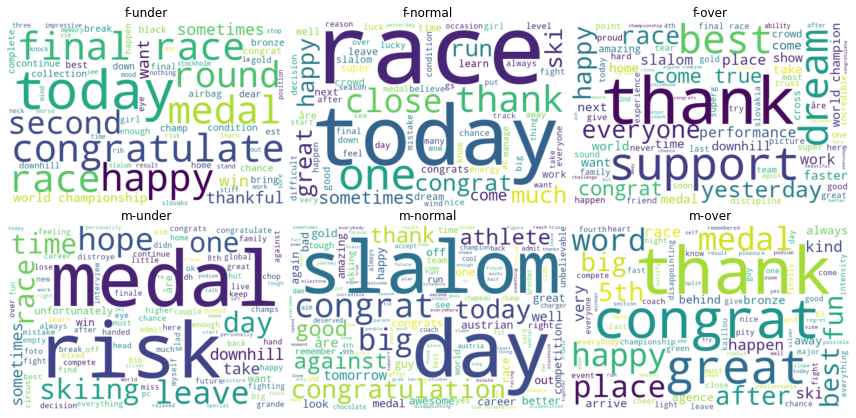

In [24]:
import itertools

fig = plt.figure(figsize=(12,6))
c=0
for i,j in itertools.product(['f', 'm'], ['under', 'normal', 'over']):
    c+=1
    subset = word_freq.loc[(word_freq.gender == i) & (word_freq.performance_075xsigma == j)]
    freq_dict = dict(zip(subset.meaning_words, subset.n))
    wordcloud = wc.WordCloud(width = 600, height = 400, background_color ='white', min_font_size = 10).generate_from_frequencies(freq_dict)
    
    fig.add_subplot(2,3,c)
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.axis('off')
    plt.title(f'{i}-{j}')
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('word_wc_panel.png', format='png')

In [51]:
frequency_top10 = word_freq.sort_values('n', ascending=False).groupby(['gender', 'performance_075xsigma']).head(10)

In [53]:
base = alt.Chart(frequency_top10).mark_bar().encode(
    x=alt.X(field='n', type='quantitative', axis=alt.Axis(title=None, tickMinStep=1)),
    y=alt.Y(field='meaning_words', type='nominal', sort='-x', axis=alt.Axis(title=None, labelFontSize=12)),
    color=alt.Color(field='n', type='quantitative', legend=None)
)

# you'd think you can simply do this via facets, but no
# not if you want to avoid having **all** the words featured in each y axis
chart = alt.vconcat().resolve_scale(x='shared')
for gender in ['f', 'm']:
    row = alt.hconcat().resolve_scale(x='shared')
    for perf in ['under', 'normal', 'over']:
        row |= base.transform_filter(f'datum.gender == "{gender}" & datum.performance_075xsigma =="{perf}"').properties(width=300,height=200,title=f'{gender}, {perf}')
    chart &= row

from altair_saver import save
save(chart,'word_frequency_panel.html')

chart

alt.VConcatChart(...)

In [25]:
import itertools

fig = plt.figure(figsize=(12,6))
c=0
for i in ['f', 'm']:
    c+=1
    subset = word_freq.loc[(word_freq.gender == i)]
    subset = subset.groupby("meaning_words")['n'].sum()
    freq_dict = dict(zip(subset.index.values, subset.values))
    wordcloud = wc.WordCloud(width = 600, height = 400, background_color ='white', min_font_size = 10).generate_from_frequencies(freq_dict)
    
    fig.add_subplot(1,2,c)
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.axis('off')
    plt.title(f'{i}')
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('word_wc_women_men.png', format='png')